<a href="https://colab.research.google.com/github/riccardotomada/Airfoil-Analysis/blob/master/Transport%20equation/ROM%20linear/POD_utilities_and_datasets_transport_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installing FEnICS
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin 

In [3]:
# Importing the libraries needed
from fenics import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.stats import qmc
import csv
from sklearn.decomposition import PCA

In [4]:
# FOM construction

# Generating the mesh
nx, ny = 100, 100
mesh = UnitSquareMesh(nx, ny)
dim = mesh.geometric_dimension()
print(dim)
mesh.coordinates().shape

2


(10201, 2)

In [5]:
# Setting up the measures
dx = Measure('dx', domain=mesh)

In [13]:
# Definition of finite element space
degree = 1
V = FunctionSpace(mesh, 'CG', degree)

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00609589 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0218976 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

In [14]:
# Data of the problem
t = 0
b  = Expression(('2*pi*(x[1]-0.5)', '2*pi*(0.5-x[0])'), degree = degree+1, domain = mesh)
xc = Expression('sin(2*pi*t)/4 + 0.5', degree = degree+1, domain = mesh, t = t)
yc = Expression('cos(2*pi*t)/4 + 0.5', degree = degree+1, domain = mesh, t = t)
f = Constant(0.0)

dt = 0.001
end_time = 1
steps = int(end_time/dt)
print(steps)

1000


In [15]:
# Generating the sampling grid to retrieve the SNapshots 

x_min, x_max = 0, 1
y_min, y_max = 0, 1
grid_dim = 96

x = np.linspace(x_min, x_max, grid_dim)
y = np.linspace(y_min, y_max, grid_dim)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

print(range(steps))

range(0, 1000)


In [16]:
# Definition of Dirichlet boundary conditions
def boundary(x, on_boundary):
  return on_boundary

In [19]:
num_samples     = 80
truncated_modes = 100
times = np.arange(0.0, 1.0, 0.01) + 0.01
times_len = times.size + 1
print(times)

import random
random.seed(123)

sampler    = qmc.LatinHypercube(d = 1, seed = 123)
parameters = sampler.random(n = num_samples)
parameters = qmc.scale(parameters, 0.5, 5.0)
parameters = np.squeeze(parameters, axis = 1)
print(parameters)

Snapshots = np.zeros((10201, parameters.shape[0] * times_len))
Snapshot_ae  = np.zeros((grid_dim**2, 1))
Snapshots_ae = np.zeros((grid_dim**2, parameters.shape[0] * times_len))

for iter in range(parameters.shape[0]):

  sig    = parameters[iter] * 200
  u0     = Expression('0.5*exp(-sig*(pow(x[0]-0.5,2)+pow(x[1]-0.75,2)))', degree = degree, domain = mesh, sig = sig)
  xc = Expression('sin(2*pi*t)/4 + 0.5', degree = degree, domain = mesh, t = t)
  yc = Expression('cos(2*pi*t)/4 + 0.5', degree = degree, domain = mesh, t = t) 
  sol_ex = Expression('0.5*exp(-sig*(pow(x[0]-xc,2)+pow(x[1]-yc,2)))', degree = degree, domain = mesh, xc = xc, yc = yc, sig = sig)

  bc = DirichletBC(V, sol_ex, boundary)
 
  u = TrialFunction(V)
  v = TestFunction(V)

  u_n = Function(V)
  a = u*v*dx + 0.5 * dt*div(b*u)*v*dx
  A = assemble(a)
  bc.apply(A)
  Ainv = LUSolver(A) 

  u = Function(V) # initialize a list (to store the solution at each time step)
  u = interpolate(u0, V) # Initial value
  u_n = u

  Snapshot = u_n.vector()
  Snapshots[:, iter*times_len] = Snapshot
  for i in range(X.shape[0]):
    Snapshot_ae[i] = u0(X[i][0], X[i][1])

  print(Snapshot_ae.shape)
  Snapshots_ae[:, iter*times_len] = Snapshot_ae[:,0]

  count = 0
  t = 0

  for n in range(steps):
    print("iter" + str(iter))

    L = (u_n + dt*f)*v*dx - 0.5 * dt*div(b*u_n)*v*dx
    B = assemble(L)
    bc.apply(B)

    # Update current time
    t += dt
    f.t= t

    # Add a new function to the list "u"
    u = Function(V)

    # Compute solution
    
    Ainv.solve(u.vector(), B)

    # Update previous solution
    u_n = u
    h   = interpolate(u, V)

    if np.isclose(times, t, atol=0.0001).any():
      count += 1
      print(count)
      Snapshot = h.vector()
      Snapshots[:, iter*times_len+count] = Snapshot
      for i in range(X.shape[0]):
        Snapshot_ae[i] = u(X[i][0], X[i][1])
      print(Snapshot_ae.shape)
      Snapshots_ae[:, iter*times_len + count] = np.squeeze(Snapshot_ae, axis = 1)

Output streaming troncato alle ultime 5000 righe.
iter75
iter75
84
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
85
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
86
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
87
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
88
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
89
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
90
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
91
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
92
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
93
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
94
(9216, 1)
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
iter75
95
(9216, 1)
iter75
ite

In [20]:
print(Snapshots[:,54].max())

0.4984611334648746


In [21]:
# Performing the Singular Value Decomposition on the Snapshots matrix
UU, SS, VV = np.linalg.svd(Snapshots, full_matrices=False)

In [23]:
print(UU.mean())
np.savetxt("UU_full_tr.txt", UU)

from google.colab import drive
drive.mount('drive')
!cp UU_full_tr.txt "drive/My Drive/Tesi/Transport/"

Mounted at drive


In [ ]:
# Inspecting the Singular Values
my_model = PCA(n_components = 0.999, svd_solver='full')
my_model.fit_transform(Snapshots)

n_modes = my_model.explained_variance_ratio_.cumsum().shape[0]
print("The number of modes required to capture the 99% of the variance is: " + str(n_modes))

(9216, 8080)
(10201, 8080)
(10201, 100)


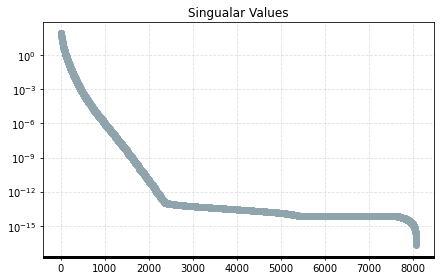

In [24]:
# Plotting the Singular Values
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(SS, marker="o", color = '#90A4AE')
plt.title("Singualar Values")
ax.xaxis.set_minor_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
plt.grid(alpha = 0.4, linestyle='--')
fig.tight_layout()
ax.set_yscale('log')

print(Snapshots_ae.shape)
print(UU.shape)

UU = UU[:, :truncated_modes]
print(UU.shape)

In [ ]:
# Retrieving the terms of the FOM for the PINN-approach
# Note: the RHS changes for each parameter

sampler    = qmc.LatinHypercube(d = 1, seed = 123)
parameters = sampler.random(n = 64)
parameters = np.squeeze(parameters, axis = 1)
B          = np.zeros((101**2, 64))


for iter in range(64):

  mu  = parameters[iter,0]
  la  = parameters[iter,1]
  u = TrialFunction(V)
  v = TestFunction(V)

  def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1.0)

  def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0.0)

  def boundary_left_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0) and (x[1] <= la)

  def boundary_left_top(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0) and (x[1] >= la)

  def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1.0)

  bc1 = DirichletBC(V, gD0, boundary_right)
  bc2 = DirichletBC(V, gD1, boundary_bottom)
  bc3 = DirichletBC(V, gD1, boundary_left_bottom)
  bc4 = DirichletBC(V, gD0, boundary_left_top)
  bc5 = DirichletBC(V, gD0, boundary_top)

  L = f * v * dx
  b = assemble(L)
  bc1.apply(b)
  bc2.apply(b)
  bc3.apply(b)
  bc4.apply(b)
  bc5.apply(b)
  B[:, iter] = np.array(b)

In [ ]:
A_array = A.array()
A_array.shape

In [ ]:
# Assembling the LHS and the RHS of the POD-ROM
LEFT_SIDE = np.matmul(np.transpose(UU), A_array)
LEFT_SIDE = np.matmul(LEFT_SIDE, UU)
print(LEFT_SIDE.shape)
RIGHT_SIDE = np.matmul(np.transpose(UU), B) 
print(RIGHT_SIDE.shape)

In [ ]:
# Solving the ROM at each parameter instance
solutions_y = np.zeros(RIGHT_SIDE.shape)
print(RIGHT_SIDE.shape)
for i in range(solutions_y.shape[1]):
  y = np.linalg.solve(LEFT_SIDE, RIGHT_SIDE[:, i])
  solutions_y[:, i] = y

print(solutions_y.T.shape)

In [ ]:
# Preparing the PINN dataset

data_PINN = np.append(res_sample, solutions_y.T, axis = 1)
print(data_PINN.shape)

In [25]:
# Retrieving the Projection Coefficients for the PDNN

pro_coeff = np.matmul(np.transpose(UU), Snapshots)
pro_coeff.shape

print(pro_coeff[:,-1])

[ 8.55198593e-01 -4.76748087e-01  3.69035070e-02 -5.57706757e-01
  2.33413918e-05 -5.62763574e-01 -1.12309606e-04 -5.55421464e-01
 -4.44766949e-04 -5.41166881e-01 -1.02481206e-03 -5.21197944e-01
 -1.89302403e-03  4.96323628e-01  3.07280377e-03  4.67701119e-01
 -4.56875204e-03 -4.36915069e-01  6.36845954e-03 -4.06021495e-01
 -8.44504795e-03 -3.78706439e-01 -1.07586733e-02 -3.76872522e-01
 -1.32585412e-02 -2.89630044e-01  1.79822631e-01 -7.61229943e-02
  2.63493298e-01  9.26522820e-04 -2.12609723e-01 -1.58742530e-02
 -1.89449840e-01  9.24076881e-04 -2.57559476e-01 -1.85345630e-02
 -1.44649811e-01  1.54587930e-03  2.57359075e-01  2.11382118e-02
  5.50428496e-02  2.63000128e-03  2.27286390e-01 -3.65896668e-02
  2.26801906e-02  7.38862759e-03 -1.94998641e-01  2.59341623e-02
 -4.25595778e-02 -4.50577964e-03  1.53460019e-01 -2.80732793e-02
  7.81886147e-02  4.74468007e-03 -1.27795991e-01 -2.98559490e-02
  7.66217839e-02 -5.44198336e-03  1.11798359e-01 -3.12624198e-02
  1.05014496e-01 -2.46090

In [26]:
# Preparing the PDNN dataset

pdnn_dataset = np.zeros((num_samples*times_len, truncated_modes + 2))
count = 0
for i in range(80):
  pdnn_dataset[80*count:80*(count+1), 0] = parameters[i]
  count += 1
pdnn_dataset[:, 0] = np.repeat(np.array(parameters), repeats = times_len)
pdnn_dataset[:, 1] = np.tile(np.insert(times, 0, 0.0), 80)
print(pdnn_dataset.shape)
pdnn_dataset[:, 2:] = pro_coeff.T
print(pdnn_dataset[79,:])

(8080, 102)
[ 1.81161771e+00  7.90000000e-01  7.79846056e-01  3.50758043e-01
  1.26475913e+00  1.27044325e+00 -6.37760475e-01  7.03272883e-01
  8.81900361e-01 -7.26995788e-01  9.52828361e-01 -9.36393132e-01
 -3.16753446e-01  1.58035029e-01 -9.00107456e-01 -7.85089040e-01
  1.39003967e-01 -2.13063067e-01  6.00290960e-01 -4.63022707e-01
 -3.38719236e-01 -3.26008999e-01 -2.68608462e-01  1.71225896e-01
 -3.19502618e-01  2.58003673e-01  4.61177062e-02 -1.27360396e-01
 -5.38442965e-02 -1.44718065e-01 -1.17459651e-01  7.74799687e-02
 -2.33780784e-02  2.04203984e-01  5.17694890e-02 -6.76477636e-02
 -1.58870565e-01  4.58959528e-02 -1.70315335e-02 -4.99791335e-02
  5.32311482e-02  9.51383034e-02 -7.62415269e-03  7.04079310e-03
 -4.38893823e-02  4.22217155e-02  5.76915604e-02 -4.20666360e-03
  2.69690624e-02 -2.95085139e-02 -5.49141256e-02  9.14314769e-03
  1.63795970e-02  3.68624317e-02  2.03439317e-02  5.08117086e-02
 -2.14943612e-02 -2.74083340e-03 -5.36465465e-02 -4.17330832e-02
 -9.68520740e

In [ ]:
from google.colab import drive
drive.mount('drive')

In [27]:
# Saving on Google Drive

np.savetxt("parameter_tr.csv", parameters, delimiter=",")
!cp parameter_tr.csv "drive/My Drive/Tesi/Transport/"
np.savetxt("coefficients_tr.csv", pro_coeff, delimiter=",")
!cp coefficients_tr.csv "drive/My Drive/Tesi/Transport/"
np.savetxt("basis_tr.csv", UU, delimiter=",")
!cp basis_tr.csv "drive/My Drive/Tesi/Transport/"
np.savetxt("snapshots_tr.csv", Snapshots, delimiter=",")
!cp snapshots_tr.csv "drive/My Drive/Tesi/Transport/"
np.savetxt("snapshots_ae_tr.csv", Snapshots_ae, delimiter=",")
!cp snapshots_ae_tr.csv "drive/My Drive/Tesi/Transport/"
#np.savetxt("LHS.csv", LEFT_SIDE, delimiter=",")
#!cp LHS.csv "drive/My Drive/"
#np.savetxt("RHS.csv", RIGHT_SIDE, delimiter=",")
#!cp RHS.csv "drive/My Drive/"
#np.savetxt("pinn_dataset.txt", data_PINN, delimiter=" ")
#!cp pinn_dataset.txt "drive/My Drive/"
np.savetxt("pdnn_dataset_tr.txt", pdnn_dataset, delimiter=" ")
!cp pdnn_dataset_tr.txt "drive/My Drive/Tesi/Transport/"